Implementación de regresión líneal manual con descenso de gradiente

In [1]:
#Importación de librerías
import numpy as np
import pandas as pd

In [2]:
#Carga de datos
data = pd.read_csv('./Student_Performance.csv')

In [3]:
data.head()  # Muestra todo el DataFrame

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


A continuación se va a evaluar la limpieza del dataset

In [4]:
# Muestra un resumen del DataFrame
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [5]:
#Verificación de valores nulos
assert data["Hours Studied"].isna().all() == False
assert data["Previous Scores"].isna().all() == False
assert data["Extracurricular Activities"].isna().all() == False
assert data["Sleep Hours"].isna().all() == False
assert data["Sample Question Papers Practiced"].isna().all() == False
assert data["Performance Index"].isna().all() == False

En la prueba anterior se probó que todas las columnas poseen datos, por lo que no hay que tratar las columnas en el sentido de eliminar alguna

In [6]:
#Verificación de datos duplicados
data.duplicated().any()

np.True_

In [7]:
#Conteo de datos duplicados
data.duplicated().sum()

np.int64(127)

In [8]:
#Mostrar filas duplicadas
data[data.duplicated()]

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
915,9,52,No,5,9,48.0
1477,7,61,Yes,6,8,54.0
1601,5,99,No,7,5,89.0
1786,2,62,Yes,9,4,40.0
2026,5,87,Yes,6,7,74.0
...,...,...,...,...,...,...
9644,4,91,Yes,4,3,71.0
9940,8,95,No,5,2,90.0
9954,6,97,No,8,7,92.0
9966,1,41,No,7,3,12.0


In [9]:
#Eliminación de filas duplicadas
data_clean = data.drop_duplicates()
data_clean.reset_index(drop=True, inplace=True)

Como se descubrio 127 filas duplicadas, se eliminaron para evitar redundacia de datos. A continuación se mostrará el dataset con una limpieza básica y su posterio análisis antes de DEA.

Como la categoría de Extracurricular Activities indica que es de tipo objeto, se realizará un cambio de tipo a boleano númerico, donde 1 es Yes y 0 es No.

In [10]:
# Cambia los valores de "Yes" y "No" a 1 y 0 respectivamente
data_clean.loc[:, "Extracurricular Activities"] = data_clean["Extracurricular Activities"].fillna("No").map({"Yes": 1, "No": 0})

In [11]:
# Muestra estadísticas descriptivas del DataFrame
data_clean.describe

<bound method NDFrame.describe of       Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0                 7               99                          1            9   
1                 4               82                          0            4   
2                 8               51                          1            7   
3                 5               52                          1            5   
4                 7               75                          0            8   
...             ...              ...                        ...          ...   
9868              1               49                          1            4   
9869              7               64                          1            8   
9870              6               83                          1            8   
9871              9               97                          1            7   
9872              7               74                          0            8   

     

In [12]:
data_clean.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     9873 non-null   int64  
 1   Previous Scores                   9873 non-null   int64  
 2   Extracurricular Activities        9873 non-null   object 
 3   Sleep Hours                       9873 non-null   int64  
 4   Sample Question Papers Practiced  9873 non-null   int64  
 5   Performance Index                 9873 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 462.9+ KB


In [13]:
# Muestra estadísticas descriptivas del DataFrame
data_clean.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,9873.000000,9873.000000,9873.000000,9873.000000,9873.000000
mean,4.992100,69.441102,6.531652,4.583004,55.216651
std,2.589081,17.325601,1.697683,2.867202,19.208570
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,70.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


A continuación se realizará el DEA

array([[<Axes: title={'center': 'Hours Studied'}>,
        <Axes: title={'center': 'Previous Scores'}>],
       [<Axes: title={'center': 'Sleep Hours'}>,
        <Axes: title={'center': 'Sample Question Papers Practiced'}>],
       [<Axes: title={'center': 'Performance Index'}>, <Axes: >]],
      dtype=object)

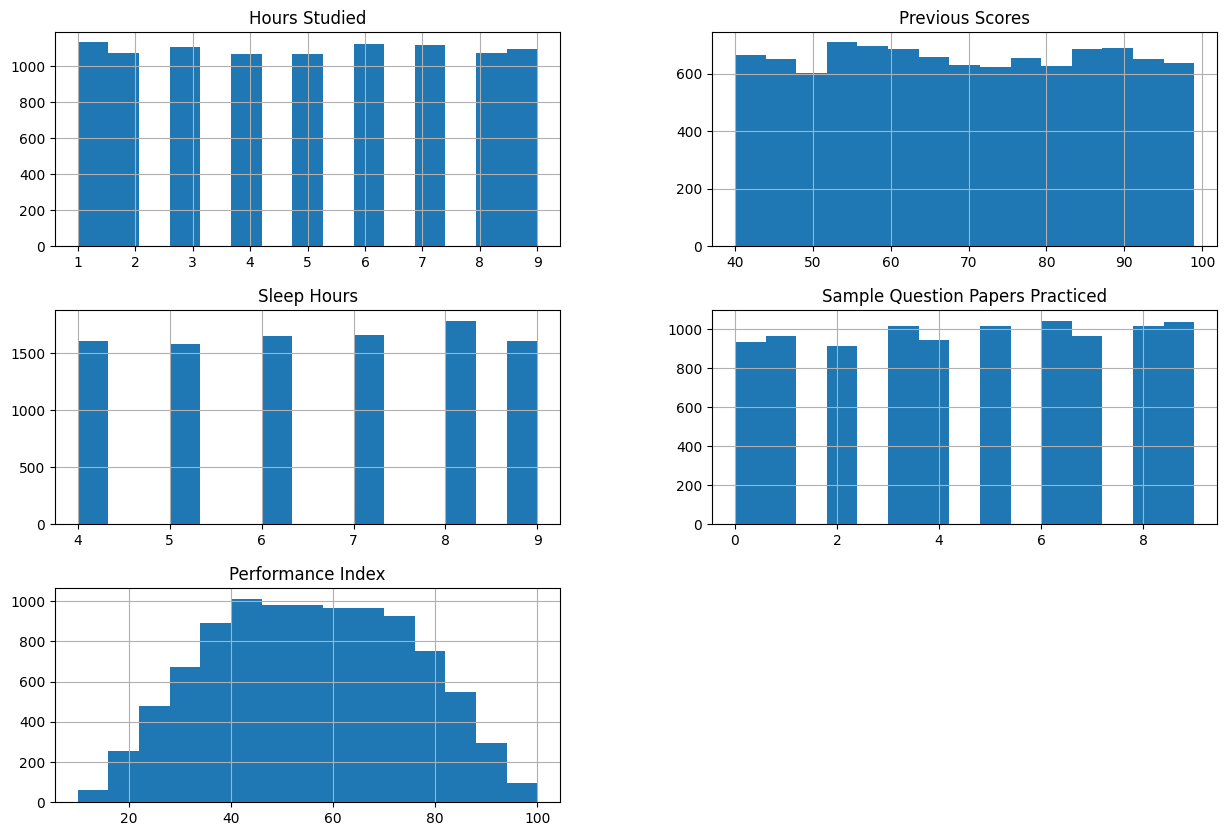

In [14]:
#histogramas de las variables numéricas de 15x10
data_clean.hist(bins=15, figsize=(15, 10))

En el primer gráfico se observa que la mayoría de los estudiantes estudia entre 1 y 2 horas o entre 8 y 9 horas antes de una evaluación. Por su parte, el gráfico del índice de rendimiento muestra que se concentra en el rango de 40 a 60, lo cual resulta consistente con las notas obtenidas en el gráfico de las evaluaciones anteriores.

Hours Studied                          Axes(0.125,0.653529;0.227941x0.226471)
Previous Scores                     Axes(0.398529,0.653529;0.227941x0.226471)
Sleep Hours                         Axes(0.672059,0.653529;0.227941x0.226471)
Sample Question Papers Practiced       Axes(0.125,0.381765;0.227941x0.226471)
Performance Index                   Axes(0.398529,0.381765;0.227941x0.226471)
dtype: object

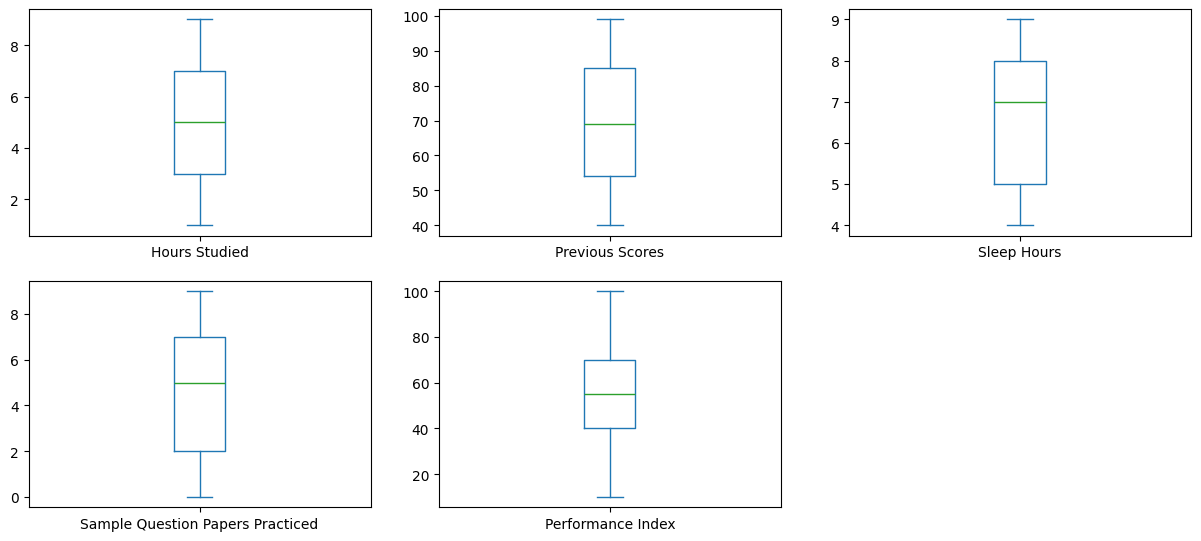

In [15]:
#Boxplot de las variables numéricas
data_clean.plot(kind='box', subplots=True, layout=(3,3), figsize=(15,10), sharex=False, sharey=False)

En el boxplot de horas estudiadas se aprecia una variabilidad media y no se observan indicios de sesgo.
El boxplot de notas anteriores también muestra una variabilidad media sin evidencias de sesgo.
En el caso de las horas de sueño, la caja es la más alta, lo que refleja una elevada variabilidad en los datos, con una distribución sesgada hacia la izquierda.
El boxplot de preguntas practicadas presenta la segunda caja más alta, indicando una alta variabilidad y un ligero sesgo a la izquierda.
Finalmente, el boxplot del índice de rendimiento muestra una baja variabilidad y ausencia de sesgo.

In [16]:
#matriz de correlación
data_clean.corr()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
Hours Studied,1.000000,-0.010676,0.004899,0.002131,0.015740,0.375332
Previous Scores,-0.010676,1.000000,0.009534,0.007975,0.008719,0.915135
Extracurricular Activities,0.004899,0.009534,1.000000,-0.024008,0.013839,0.026075
Sleep Hours,0.002131,0.007975,-0.024008,1.000000,0.004907,0.050352
Sample Question Papers Practiced,0.015740,0.008719,0.013839,0.004907,1.000000,0.043436
Performance Index,0.375332,0.915135,0.026075,0.050352,0.043436,1.000000


Los valores de la matriz de correlación son, cercano a 1: correlación positiva fuerte, -1: correlación negativa fuerte y 0: poca o nula correlación

En la matriz anterior se observa una fuerte correlación entre las categorías de Performance Index, Hours Studied y Previous Scores. Las demás correlaciones son cercanas a 0

**Nota**: Hay valores que dan 1, pero es de la categoría con si misma, por lo que se omite en el análisis

In [17]:
# Se toman las variables numéricas continuas, luego se transforman en categorías (bins) y se analiza el balance de datos en cada categoría
num_cols = data_clean.select_dtypes(include=["float64", "int64"]).columns

# Definir número de bins (rangos)
bins = 5  # puedes ajustar según necesites

# Crear un diccionario para guardar los resultados
balance_summary = {}

for col in num_cols:
    # Crear bins (rangos) usando pd.cut
    binned = pd.cut(data_clean[col], bins=bins)
    
    # Contar cuántos datos caen en cada rango y calcular porcentaje
    counts = binned.value_counts()
    percent = binned.value_counts(normalize=True) * 100
    
    # Guardar en el diccionario
    balance_summary[col] = pd.DataFrame({"count": counts, "proportion (%)": percent})

# Mostrar resultados
for col, df_summary in balance_summary.items():
    print(f"\nBalance por rangos de '{col}':")
    print(df_summary.sort_index())


Balance por rangos de 'Hours Studied':
               count  proportion (%)
Hours Studied                       
(0.992, 2.6]    2210       22.384280
(2.6, 4.2]      2181       22.090550
(4.2, 5.8]      1069       10.827509
(5.8, 7.4]      2240       22.688139
(7.4, 9.0]      2173       22.009521

Balance por rangos de 'Previous Scores':
                 count  proportion (%)
Previous Scores                       
(39.941, 51.8]    1919       19.436848
(51.8, 63.6]      2092       21.189102
(63.6, 75.4]      1913       19.376076
(75.4, 87.2]      1970       19.953408
(87.2, 99.0]      1979       20.044566

Balance por rangos de 'Sleep Hours':
              count  proportion (%)
Sleep Hours                        
(3.995, 5.0]   3185       32.259698
(5.0, 6.0]     1645       16.661602
(6.0, 7.0]     1653       16.742631
(7.0, 8.0]     1784       18.069482
(8.0, 9.0]     1606       16.266586

Balance por rangos de 'Sample Question Papers Practiced':
                                  cou

El análisis del balance de las variables continuas agrupadas en rangos muestra lo siguiente:

Hours Studied presenta una distribución relativamente uniforme en la mayoría de los rangos, aunque el intervalo intermedio (4.2–5.8 horas) concentra menos datos (10.8%), indicando un ligero desbalance.

Previous Scores está balanceado, con porcentajes muy similares en todos los rangos (19–21%).

Sleep Hours evidencia un desbalance, ya que el primer rango (3.99–5 horas) concentra un 32% de los datos, mientras que los otros rangos tienen aproximadamente entre 16 y 18%.

Sample Question Papers Practiced está balanceado, con distribución uniforme entre los rangos (19–21%).

Performance Index muestra un desbalance notable, con la mayoría de los datos concentrados en los rangos centrales (28–82), y solo alrededor del 8–9% en los rangos extremos.

En general, la mayoría de las variables presentan una distribución aceptablemente uniforme, excepto Sleep Hours y Performance Index, que requieren atención al interpretar los resultados de análisis estadísticos o de eficiencia, debido a la concentración de datos en rangos específicos.

In [18]:
#Detección de outliers con IQR
Q1 = data_clean.quantile(0.25)
Q3 = data_clean.quantile(0.75)
IQR = Q3 - Q1
# Umbrales para detectar outliers
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Crear máscara de outliers (True donde hay outlier)
outlier_mask = (data_clean < lower) | (data_clean > upper)

# Filtrar filas con al menos un outlier
outlier_rows = data_clean[outlier_mask.any(axis=1)]

# Contar outliers por columna
outlier_counts = outlier_mask.sum()

# Mostrar resultados
print("Filas con al menos un outlier:")
print(outlier_rows)
print("\nConteo de outliers por columna:")
print(outlier_counts)

Filas con al menos un outlier:
Empty DataFrame
Columns: [Hours Studied, Previous Scores, Extracurricular Activities, Sleep Hours, Sample Question Papers Practiced, Performance Index]
Index: []

Conteo de outliers por columna:
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


El análisis de outliers basado en el rango intercuartílico (IQR) muestra que ninguna de las variables del dataset presenta valores atípicos. Esto indica que los datos son consistentes y no existen observaciones extremas que puedan distorsionar los resultados de análisis posteriores. En consecuencia, no es necesario realizar ningún tratamiento adicional sobre los datos.

## División de Dataset

In [19]:
def random_sampling(data, valid_ratio, test_ratio):
    indices = np.random.permutation(len(data))
    valid_set_size = int(len(data) * valid_ratio)
    test_set_size = int(len(data) * test_ratio)
    valid_indices = indices[:valid_set_size]
    test_indices = indices[valid_set_size: (valid_set_size + test_set_size)]
    train_indices = indices[(valid_set_size + test_set_size) :]
    return data.iloc[train_indices], data.iloc[test_indices], data.iloc[valid_indices]

In [20]:
train, test, valid = random_sampling(data_clean, 0.1, 0.2)

In [21]:
len(train)

6912

In [22]:
len(test)

1974

In [23]:
len(valid)

987

In [24]:
data_clean["cat_performance"] = pd.cut(data_clean["Performance Index"], bins=[0, 20, 40, 60, 80, 100], labels=[1, 2, 3, 4, 5])

C:\Users\isaac\AppData\Local\Temp\ipykernel_20276\3988949274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["cat_performance"] = pd.cut(data_clean["Performance Index"], bins=[0, 20, 40, 60, 80, 100], labels=[1, 2, 3, 4, 5])


In [25]:
percent = data_clean["cat_performance"].value_counts()
percent

cat_performance
3    3274
4    3013
2    2265
5    1056
1     265
Name: count, dtype: int64

In [26]:
def stratified_random_sampling(data, feature_name, valid_ratio, test_ratio, bin_labels):
    valid_set_size = len(data) * valid_ratio
    test_set_size = len(data) * test_ratio
    
    train_indices = []
    valid_indices = []
    test_indices = []
    
    for label in bin_labels:
        category_indices = data[data[feature_name] == label].index.values
        
        randomized_category_indices = np.random.permutation(category_indices)

        valid_category_size = int(valid_ratio * len(randomized_category_indices))
        test_category_size = int(test_ratio * len(randomized_category_indices))
        
        valid_end = valid_category_size
        test_end = valid_category_size + test_category_size
        
        valid_indices.extend(randomized_category_indices[:valid_end])
        test_indices.extend(randomized_category_indices[valid_end: test_end])
        train_indices.extend(randomized_category_indices[test_end:])

    valid_indices = np.array(valid_indices)
    test_indices = np.array(test_indices)
    train_indices = np.array(train_indices)
    
    return data.iloc[train_indices], data.iloc[valid_indices], data.iloc[test_indices]

In [27]:
train_set, valid_set, test_set = stratified_random_sampling(data_clean, "cat_performance", 0.15, 0.15, [1,2,3,4,5])

In [28]:
assert (len(train_set) + len(valid_set) + len(test_set)) == len(data_clean)

In [29]:
# Selección de features (todas excepto el target)
X = data_clean.drop(columns=["Performance Index", "cat_performance"]).values

# Target
y = data_clean["Performance Index"].values.reshape(-1, 1)  # columna vertical

# Número de muestras
m = X.shape[0]

# Agregar columna de 1s para el término independiente
X = np.hstack([np.ones((m, 1)), X])


In [30]:
print("Shape de X (features):", X.shape)
print("Shape de y (target):", y.shape)

Shape de X (features): (9873, 6)
Shape de y (target): (9873, 1)


In [31]:
# Número de features
n_features = X.shape[1]

# Inicialización de pesos
theta = np.zeros((n_features, 1))

# Tasa de aprendizaje
alpha = 0.0001

# Número de iteraciones
n_iter = 1000


Disminuir el Alfa y Aumentar las Iteraciones nos permitira encontrar un MSE mucho mas preciso, se utiliza por el momento alfa 0.0001 y 1000 iteraciones

In [32]:
#Función de Costo (MSE)
def compute_mse(X, y, theta):
    m = len(y)
    y_pred = X.dot(theta)
    mse = (1/m) * np.sum((y_pred - y)**2)
    return mse

In [33]:
#Implementación del Decenso Gradiente
# Guardar el historial del MSE
mse_history = []

for i in range(n_iter):
    # Predicciones
    y_pred = X.dot(theta)
    
    # Gradiente
    grad = (2/m) * X.T.dot(y_pred - y)
    
    # Actualizar pesos
    theta = theta - alpha * grad
    
    # Guardar MSE
    mse = compute_mse(X, y, theta)
    mse_history.append(mse)
    
    # Imprimir cada 100 iteraciones
    if i % 100 == 0:
        print(f"Iteración {i}, MSE: {mse:.4f}")


Iteración 0, MSE: 78.5898
Iteración 100, MSE: 64.8571
Iteración 200, MSE: 58.6319
Iteración 300, MSE: 53.7579
Iteración 400, MSE: 49.9187
Iteración 500, MSE: 46.8766
Iteración 600, MSE: 44.4524
Iteración 700, MSE: 42.5096
Iteración 800, MSE: 40.9442
Iteración 900, MSE: 39.6760


En este bloque se imprime el MSE cada 100 iteraciones.
El MSE mide qué tan lejos están las predicciones del modelo respecto a los valores reales.
Un MSE alto significa que el modelo se equivoca mucho; un MSE bajo indica que las predicciones se acercan más a la realidad.
Si el gradiente descendente funciona correctamente, el MSE debe ir disminuyendo a medida que avanzan las iteraciones.

En nuestro caso, observamos que:
En la iteración 0 el error es aproximadamente 78.
Después de 900 iteraciones, el error baja hasta alrededor de 39.

Esto nos indica que el modelo sí está aprendiendo y que el algoritmo está convergiendo hacia una solución más precisa.

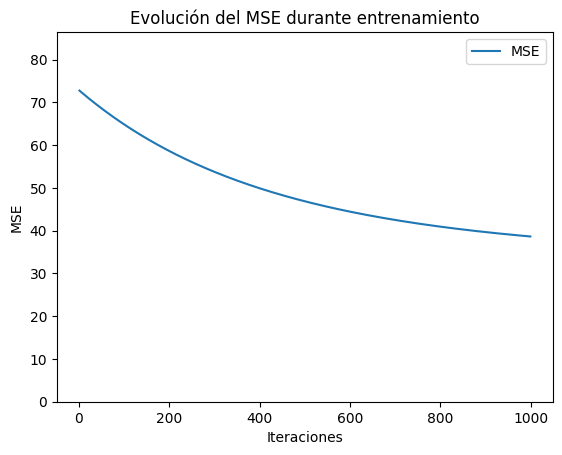

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(1,n_iter), mse_history[1:], label='MSE')
plt.xlabel('Iteraciones')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante entrenamiento')
plt.ylim(0, max(mse_history)*1.1)
plt.legend()
plt.show()


In [35]:
# Predicciones sobre todo el dataset (o sobre train/valid más adelante)
y_pred = X.dot(theta)

# Mostrar primeros 10 valores reales vs predichos
comparison = pd.DataFrame({"Actual": y.flatten(), "Predicho": y_pred.flatten()})
comparison.head(10)

,Actual,Predicho
0,91.0,81.660435
1,65.0,67.09321
2,45.0,46.691375
3,36.0,44.266374
4,66.0,62.565096
5,61.0,57.687604
6,63.0,62.891043
7,42.0,43.168264
8,61.0,61.775605
9,69.0,73.105729
